## Plot the generated daily soil and runoff cation concentrations

In [1]:
import os
import xarray as xr
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shared_read_HBR import *
from matplotlib import rcParams

site = 'HBR'

rcParams['font.size'] = 16
rcParams['axes.titlesize'] = 18

In [2]:
if site == 'HBR':
    flist_1 = [os.path.join(os.environ['PROJDIR'], 'E3SM', 'output', 
                            'ERW_HBR_ICB20TRCNPRDCTCBC', 'run', 
                            f'ERW_HBR_ICB20TRCNPRDCTCBC.elm.h1.{yy}-01-01-00000.nc') \
               for yy in range(1980, 1998)]
    flist_2 = [os.path.join(os.environ['PROJDIR'], 'E3SM', 'output', 
                            'ERW_20240310_HBR_ICB20TRCNPRDCTCBC', 'run', 
                            f'ERW_20240310_HBR_ICB20TRCNPRDCTCBC.elm.h1.{yy}-01-01-00000.nc') \
               for yy in range(1998, 2014)]
else:
    flist_1 = [os.path.join(os.environ['PROJDIR'], 'E3SM', 'output', 
                            'ERW_UC_Davis_ICB20TRCNPRDCTCBC', 'run', 
                            f'ERW_UC_Davis_ICB20TRCNPRDCTCBC.elm.h1.{yy}-01-01-00000.nc') \
               for yy in range(1980, 2018)]
    flist_2 = [os.path.join(os.environ['PROJDIR'], 'E3SM', 'output', 
                            'ERW_20231110_UC_Davis_ICB20TRCNPRDCTCBC', 'run', 
                            f'ERW_20231110_UC_Davis_ICB20TRCNPRDCTCBC.elm.h1.{yy}-01-01-00000.nc') \
               for yy in range(2018, 2023)]

hr = xr.open_mfdataset(flist_1 + flist_2)
tvec = pd.DatetimeIndex([pd.Timestamp(year=t.year, month=t.month, day=t.day) for t in hr['time'].values])

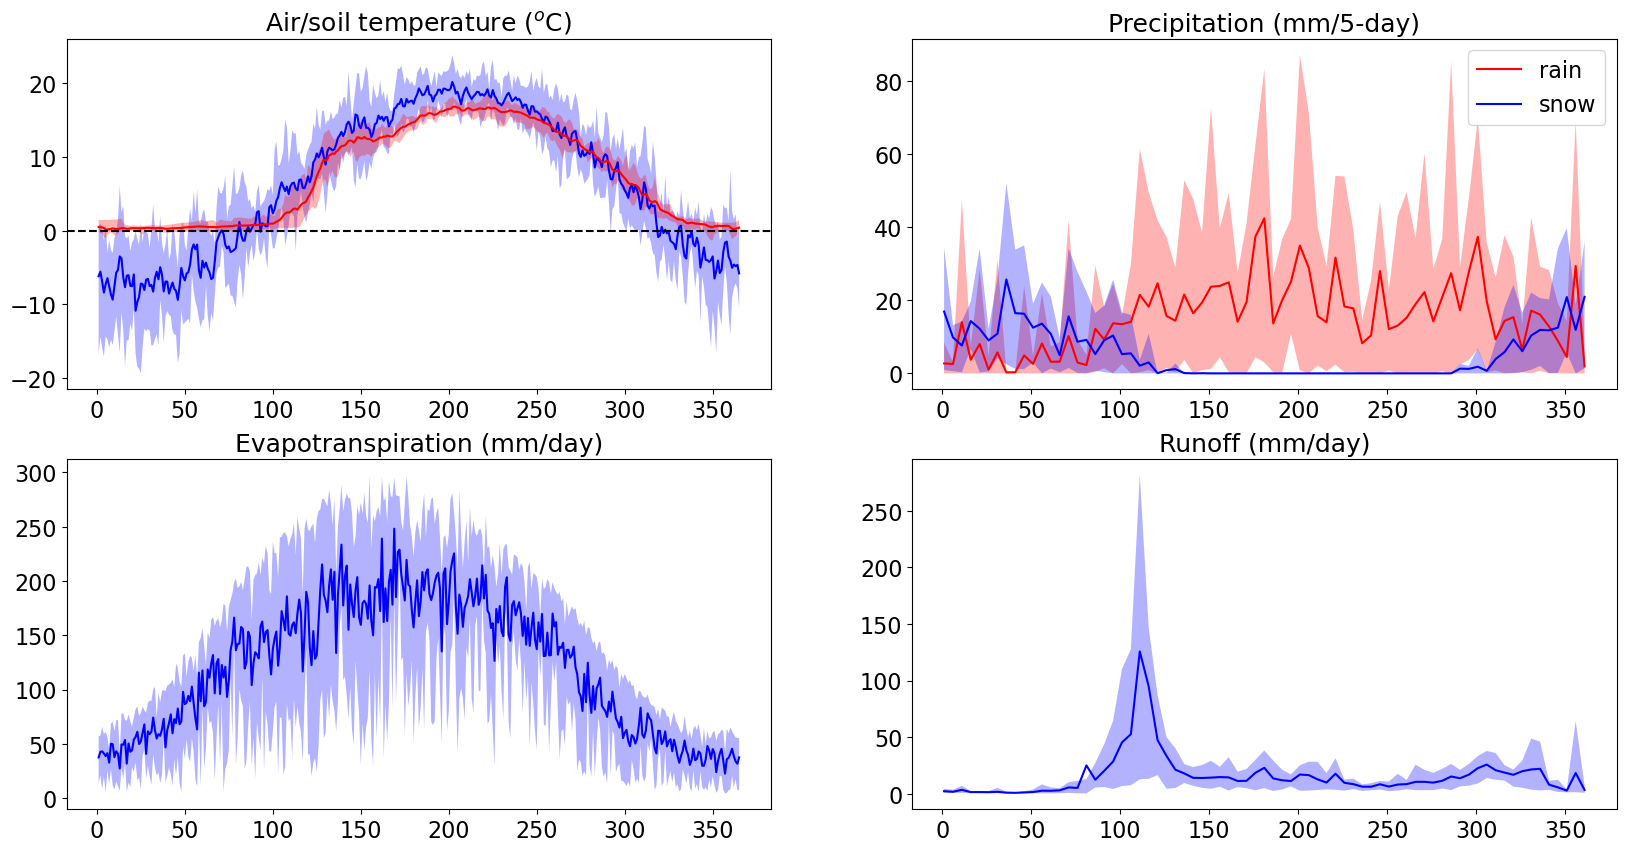

In [12]:
met_sim = pd.DataFrame({
    'rain': hr['RAIN'][:, 0] * 86400,
    'snow': hr['SNOW'][:, 0] * 86400, 
    'tair': hr['TBOT'][:, 0] - 273.15,
    'et': (hr['QVEGE'] + hr['QVEGT'] + hr['QSOIL'])[:, 0]*86400,
    'runoff': hr['QRUNOFF'][:, 0] * 86400,
    'tsoil': (np.matmul(hr['TSOI'][:, :6, 0].values,
                        hr['levgrnd'][:6].values.reshape(-1,1)) / \
              np.sum(hr['levgrnd'][:6].values) - 273.15)[:,0], # average TSOIL of 30cm
    'srad': hr['FSDS'][:, 0]
}, index = tvec[:])

# daily annual cycle
fig, axes = plt.subplots(2, 2, figsize = (20,10))

ax = axes.flat[0]
metbox = met_sim['tair'].values.reshape(-1, 365)
ax.plot(range(1, 366), metbox.mean(axis = 0), '-b', label = 'Tair')
ax.fill_between(
    range(1, 366),
    np.nanpercentile(metbox, 10, axis = 0),
    np.nanpercentile(metbox, 90, axis = 0), 
    fc = 'b', alpha = 0.3
)
metbox = met_sim['tsoil'].values.reshape(-1, 365)
ax.plot(range(1, 366), metbox.mean(axis = 0), '-r', label = 'Tsoil')
ax.fill_between(
    range(1, 366),
    np.nanpercentile(metbox, 10, axis = 0),
    np.nanpercentile(metbox, 90, axis = 0), 
    fc = 'r', alpha = 0.3
)
ax.axhline(0, ls = '--', color = 'k')
ax.set_title('Air/soil temperature ($^o$C)')

# resample to 5-day sums to smooth things out
ax = axes.flat[1]
clist = ['r','b']
for i, var in enumerate(['rain', 'snow']):
    metbox = met_sim[var].values.reshape(-1, 73, 5).sum(axis = 2) # pentad totals
    ax.plot(range(1, 366, 5), metbox.mean(axis = 0), '-', color = clist[i], label = var)
    ax.fill_between(
        range(1, 366, 5),
        np.nanpercentile(metbox, 10, axis = 0),
        np.nanpercentile(metbox, 90, axis = 0), 
        fc = clist[i], alpha = 0.3
    )
ax.set_title('Precipitation (mm/5-day)')
ax.legend()
#ax.set_yscale('log')

ax = axes.flat[2]
metbox = met_sim['srad'].values.reshape(-1, 365)
ax.plot(range(1, 366), metbox.mean(axis = 0), '-b')
ax.fill_between(
    range(1, 366),
    np.nanpercentile(metbox, 10, axis = 0),
    np.nanpercentile(metbox, 90, axis = 0), 
    fc = 'b', alpha = 0.3
)
ax.set_title('Evapotranspiration (mm/day)')

ax = axes.flat[3]
metbox = met_sim['runoff'].values.reshape(-1, 73, 5).sum(axis = 2) # pantad totals
ax.plot(range(1, 366, 5), metbox.mean(axis = 0), '-b')
ax.fill_between(
    range(1, 366, 5),
    np.nanpercentile(metbox, 10, axis = 0),
    np.nanpercentile(metbox, 90, axis = 0), 
    fc = 'b', alpha = 0.3
)
ax.set_title('Runoff (mm/day)')

+

+
plt.savefig('./temp/hbr_met.png', dpi = 600., bbox_inches = 'tight')

/autofs/nccsopen-svm1_home/ywo/Git/erw_scripts/shared_read_HBR.py:35: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data',
/autofs/nccsopen-svm1_home/ywo/Git/erw_scripts/shared_read_HBR.py:39: PerformanceWarning: indexing past lexsort depth may impact performance.
  data = data.loc['STA2', 'swe']


Text(0.5, 1.0, 'Snow water equivalent (mm)')

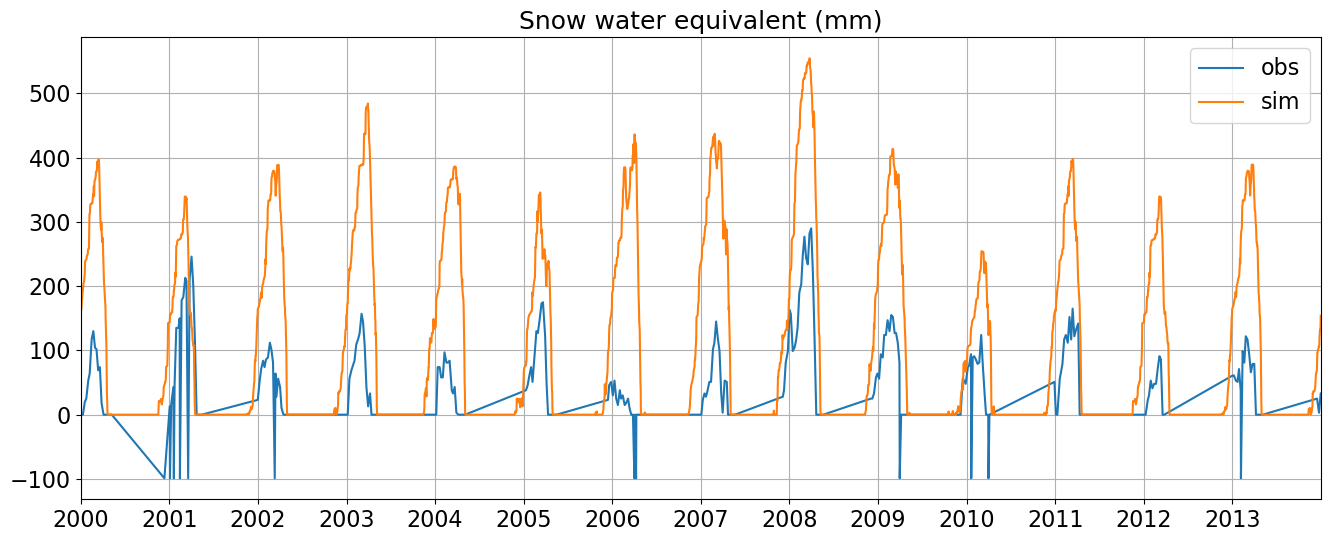

In [4]:
swe_obs = read_snowcourse()
swe_sim = pd.Series(hr['H2OSNO'][:, 0], index = tvec[:])

swe_obs = swe_obs.loc[(swe_obs.index >= swe_sim.index[0]) & (swe_obs.index <= swe_sim.index[-1])]

fig, ax = plt.subplots(figsize = (16,6))
ax.plot(swe_obs.index, swe_obs, label = 'obs')
ax.plot(swe_sim.index, swe_sim, label = 'sim')
ax.legend()
ax.set_xticks(pd.date_range('2000-01-01', '2013-12-31', freq = '1YS'))
ax.set_xticklabels(range(2000, 2014))
ax.set_xlim([pd.Timestamp('2000-01-01'), pd.Timestamp('2013-12-31')])
ax.grid(True)
ax.set_title('Snow water equivalent (mm)')

Text(0.5, 1.0, 'Annual maximum leaf area index')

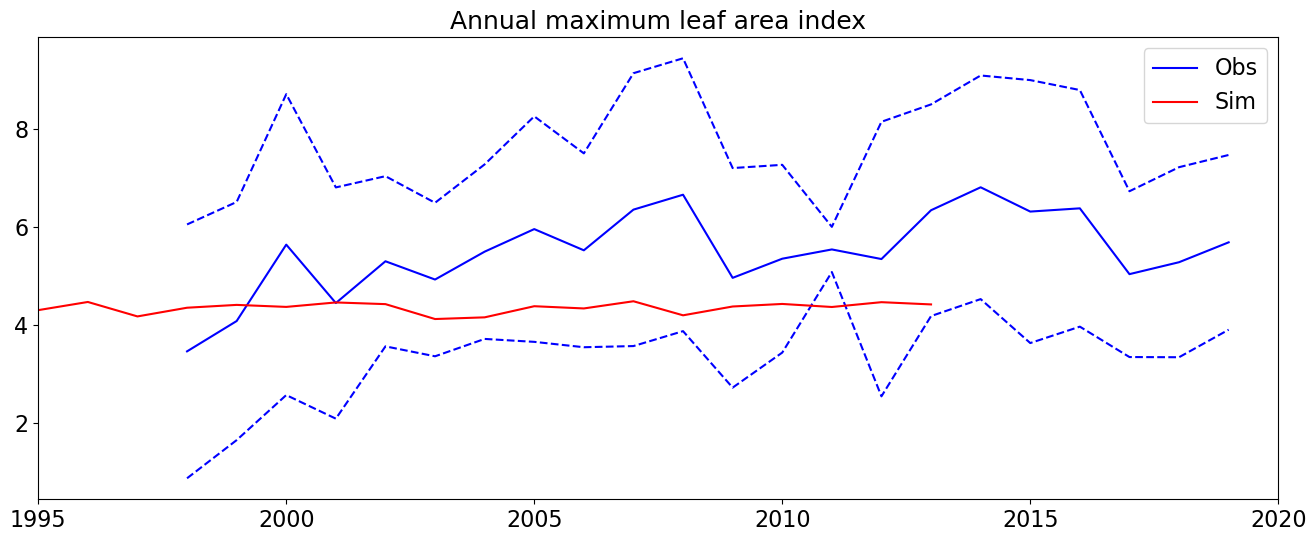

In [5]:
# annual maximum LAI
lai_obs = read_lai()
lai_obs_mean = lai_obs.groupby('Year').mean()
lai_obs_std = lai_obs.groupby('Year').std()

lai_sim = pd.Series(hr['TLAI'][:, 0], index = tvec[:])
lai_sim_mean = lai_sim.resample('1Y').max()

fig, ax = plt.subplots(figsize = (16, 6))
ax.plot(lai_obs_mean.index, lai_obs_mean, '-b', label = 'Obs')
ax.plot(lai_obs_std.index, lai_obs_mean - 2*lai_obs_std, '--b')
ax.plot(lai_obs_std.index, lai_obs_mean + 2*lai_obs_std, '--b')
ax.plot(lai_sim_mean.index.year, lai_sim_mean, '-r', label = 'Sim')
ax.legend()
ax.set_xlim([1995, 2020])
ax.set_title('Annual maximum leaf area index')

Text(0.5, 1.0, 'Leaf area index')

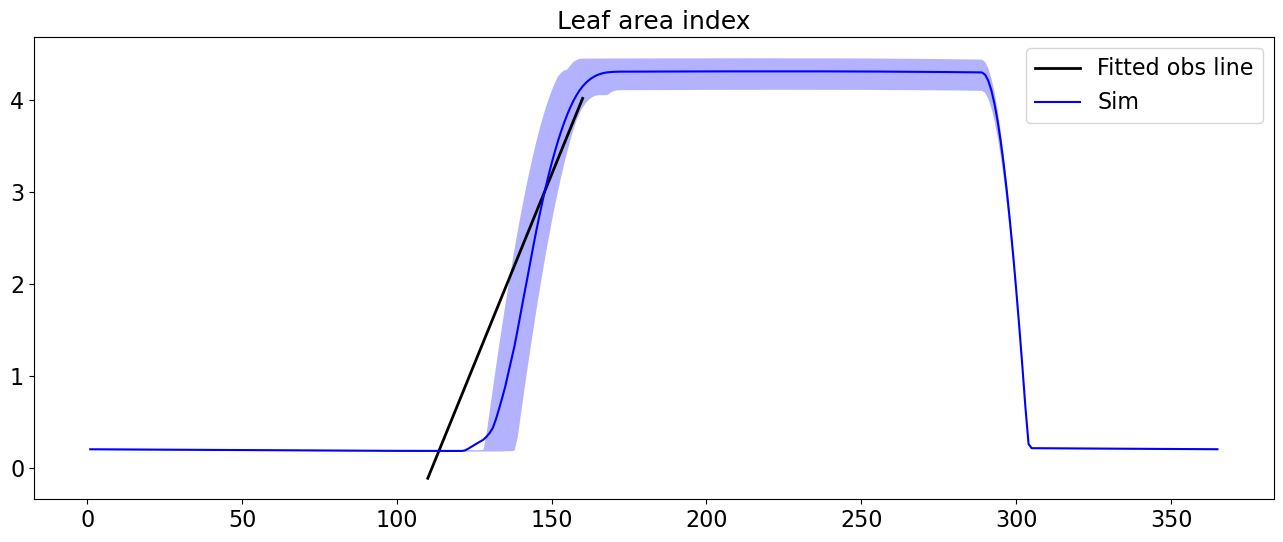

In [6]:
# daily annual cycle
lai_sim = pd.Series(hr['TLAI'][:, 0], index = tvec[:])
slope, intercept, slope_std = read_pheno()

fig, ax = plt.subplots(figsize = (16, 6))

data = lai_sim.values.reshape(-1, 365)
ax.plot([110, 160], [110*slope + intercept, 160*slope + intercept], '-k', lw = 2, 
        label = 'Fitted obs line')
ax.plot(range(1, 366), data.mean(axis = 0), '-b', label = 'Sim')
ax.fill_between(
    range(1, 366),
    np.nanpercentile(data, 10, axis = 0),
    np.nanpercentile(data, 90, axis = 0), 
    fc = 'b', alpha = 0.3
)
ax.legend()
ax.set_title('Leaf area index')

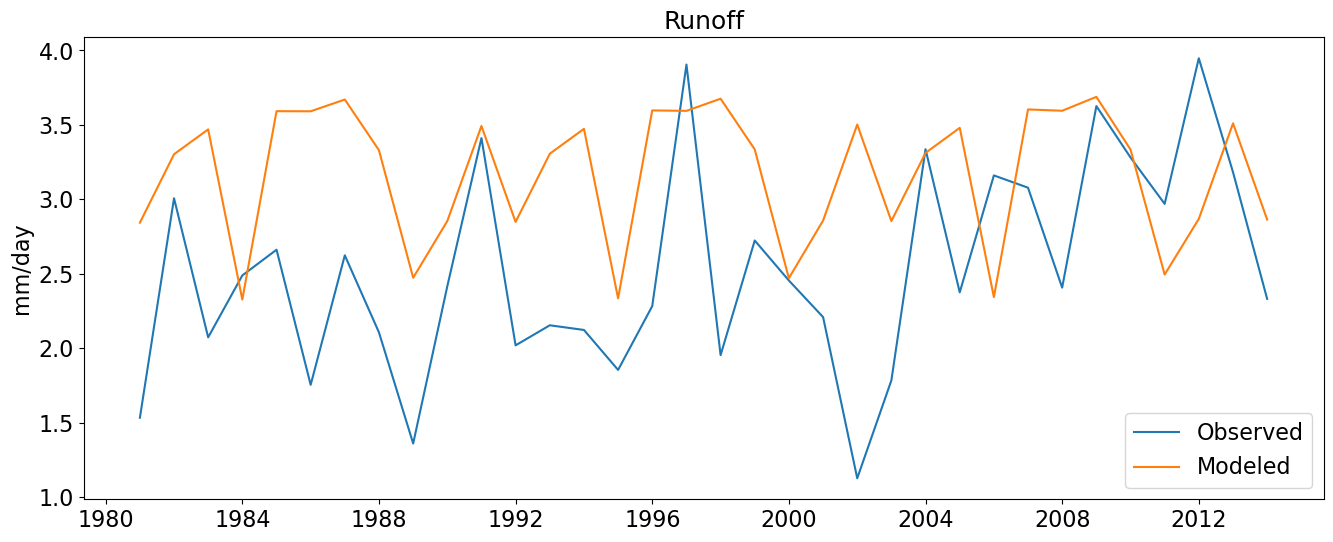

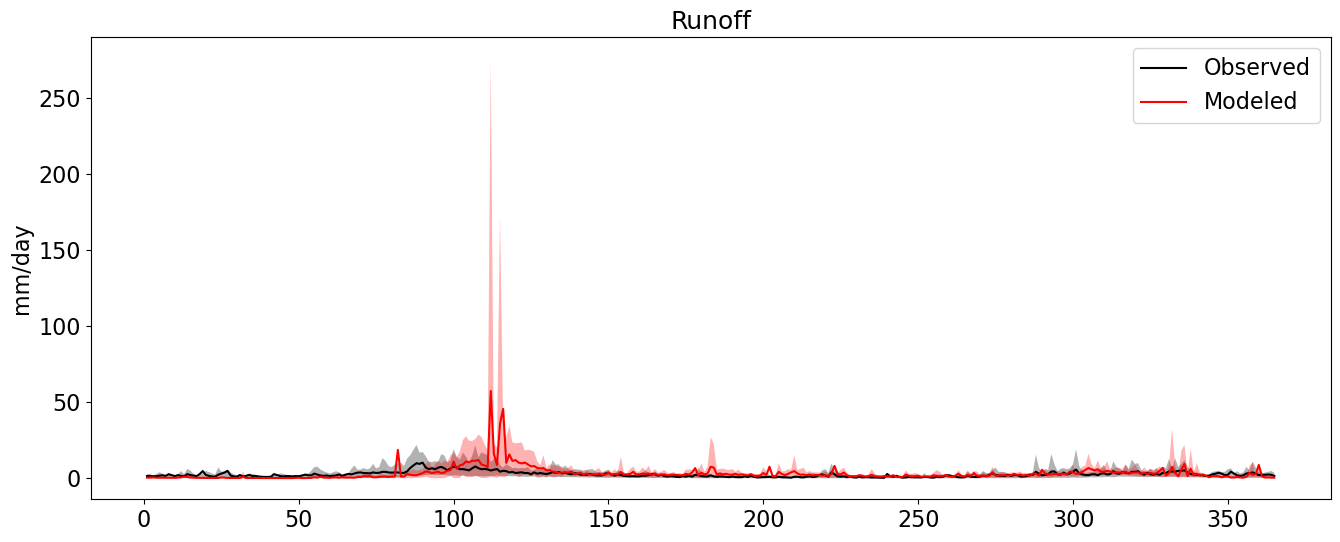

In [7]:
runoff_obs = read_runoff() # mm/day
runoff_sim = pd.Series(
    hr['QRUNOFF'][:, 0] * 86400, 
    index = tvec[:]
)

common_index = runoff_obs.index.intersection(runoff_sim.index)

# annual time series
fig, ax = plt.subplots(figsize = (16,6))
obs_ann = runoff_obs.loc[common_index].resample('1Y').mean()
sim_ann = runoff_sim.loc[common_index].resample('1Y').mean()
ax.plot(obs_ann.index, obs_ann, label = 'Observed')
ax.plot(sim_ann.index, sim_ann, label = 'Modeled')
ax.set_xlabel('')
ax.set_ylabel('mm/day')
ax.legend()
ax.set_title('Runoff')
plt.savefig('./temp/hbr_runoff_annual.png', dpi = 600., bbox_inches = 'tight')


# daily annual cycle
fig, ax = plt.subplots(figsize = (16,6))

obs_box = runoff_obs.loc[common_index].values.reshape(-1, 365)
ax.plot(range(1, 366), obs_box.mean(axis = 0), '-k', label = 'Observed')
ax.fill_between(
    range(1, 366),
    np.nanpercentile(obs_box, 10, axis = 0),
    np.nanpercentile(obs_box, 90, axis = 0), 
    fc = 'k', alpha = 0.3
)

sim_box = runoff_sim.loc[common_index].values.reshape(-1, 365)
ax.plot(range(1, 366), sim_box.mean(axis = 0), '-r', label = 'Modeled')
ax.fill_between(
    range(1, 366),
    np.nanpercentile(sim_box, 10, axis = 0),
    np.nanpercentile(sim_box, 90, axis = 0), 
    fc = 'r', alpha = 0.3
)
#ax.set_yscale('log')
ax.set_xlabel('')
ax.set_ylabel('mm/day')
ax.legend()
ax.set_title('Runoff')
plt.savefig('./temp/hbr_runoff.png', dpi = 600., bbox_inches = 'tight')

/autofs/nccsopen-svm1_home/ywo/Git/erw_scripts/shared_read_HBR.py:96: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data',


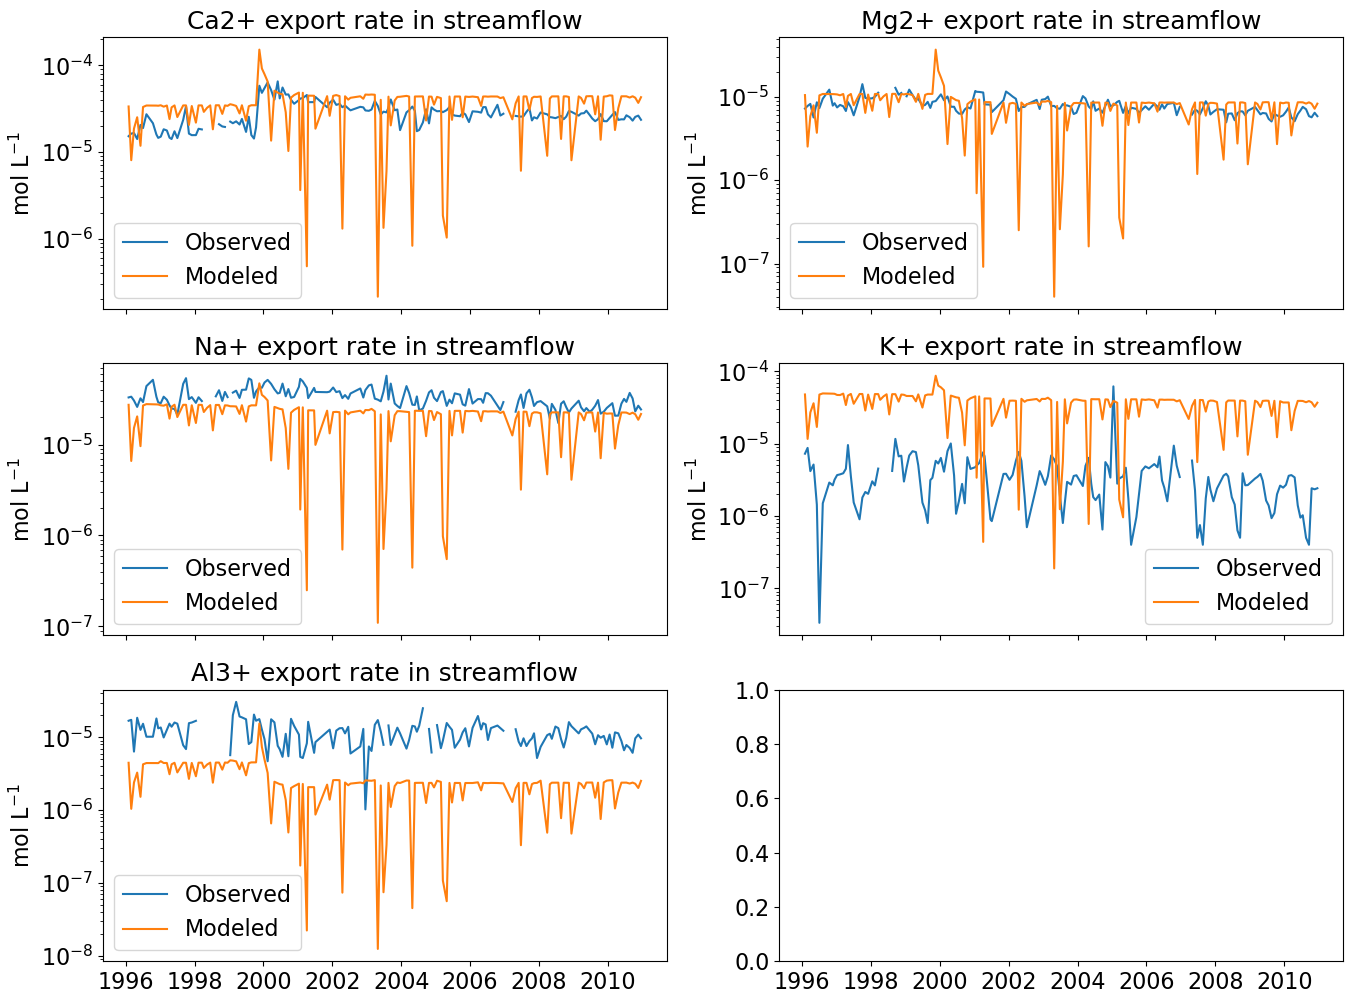

In [8]:
# Mismatch in this variable is reasonable, because 
# the model simulated result is runoff & drainage loss from top 30cm soil
# streamflow concentration is to a large extent controled by groundwater processes

cation_export_obs = read_streamChem() * 1e-6 # umol/L -> mol/L


LEVGRND = np.array([0.007100635, 0.027925, 0.06225858, 0.1188651, 0.2121934,
                    0.3660658, 0.6197585, 1.038027, 1.727635, 2.864607, 4.739157,
                    7.829766, 12.92532, 21.32647, 35.17762])
LEVGRND_I = np.append(np.insert(
    (LEVGRND[1:] + LEVGRND[:-1])*0.5, 0, 0
), LEVGRND[-1] + 0.5 * (LEVGRND[-1] - LEVGRND[-2]))
THICKNESS = np.diff(LEVGRND_I)

top_layer_water = np.matmul(hr['H2OSOI'][:, :6, 0].values, (THICKNESS[:6].reshape(-1, 1)))
all_water = np.matmul(hr['H2OSOI'][:, :, 0].values, THICKNESS.reshape(-1,1))

cation_export_sim = pd.DataFrame(
    (hr['cation_leached'][:, :, 0] + hr['cation_runoff'][:, :, 0]) / \
    ((hr['QRUNOFF'] + hr['QDRAI'])[:,0].values.reshape(-1,1) * top_layer_water / all_water),
    index = tvec, columns = ['Ca2+','Mg2+','Na+','K+','Al3+'])

cation_export_obs = cation_export_obs.loc[
    (cation_export_obs.index.year >= 1996) & 
    (cation_export_obs.index.year <= 2010)]
cation_export_sim = cation_export_sim.loc[
    (cation_export_sim.index.year >= 1996) & 
    (cation_export_sim.index.year <= 2010), :]

cation_export_sim = cation_export_sim.loc[
    cation_export_obs.index.intersection(cation_export_sim.index), :]

fig, axes = plt.subplots(3, 2, figsize = (16, 12), sharex = True)
for i, (obs_ca, sim_ca, mass_ca) in enumerate(
    zip(['Ca2', 'Mg2', 'Na', 'K', 'Alt'],
        ['Ca2+','Mg2+','Na+','K+','Al3+'],
        [40, 24, 23, 29, 27])
):
    ax = axes.flat[i]

    ax.plot(cation_export_obs.index, cation_export_obs[obs_ca], label = 'Observed')
    ax.plot(cation_export_sim.index, cation_export_sim[sim_ca] / mass_ca,
            label = 'Modeled')

    ax.set_xlabel('')
    ax.set_ylabel('mol L$^{-1}$')
    ax.set_yscale('log')
    ax.legend()
    ax.set_title(f'{sim_ca} export rate in streamflow')
plt.savefig('./temp/hbr_cation_export.png', dpi = 600., bbox_inches = 'tight')

/autofs/nccsopen-svm1_home/ywo/Git/erw_scripts/shared_read_HBR.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data',
/autofs/nccsopen-svm1_home/ywo/Git/erw_scripts/shared_read_HBR.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data',


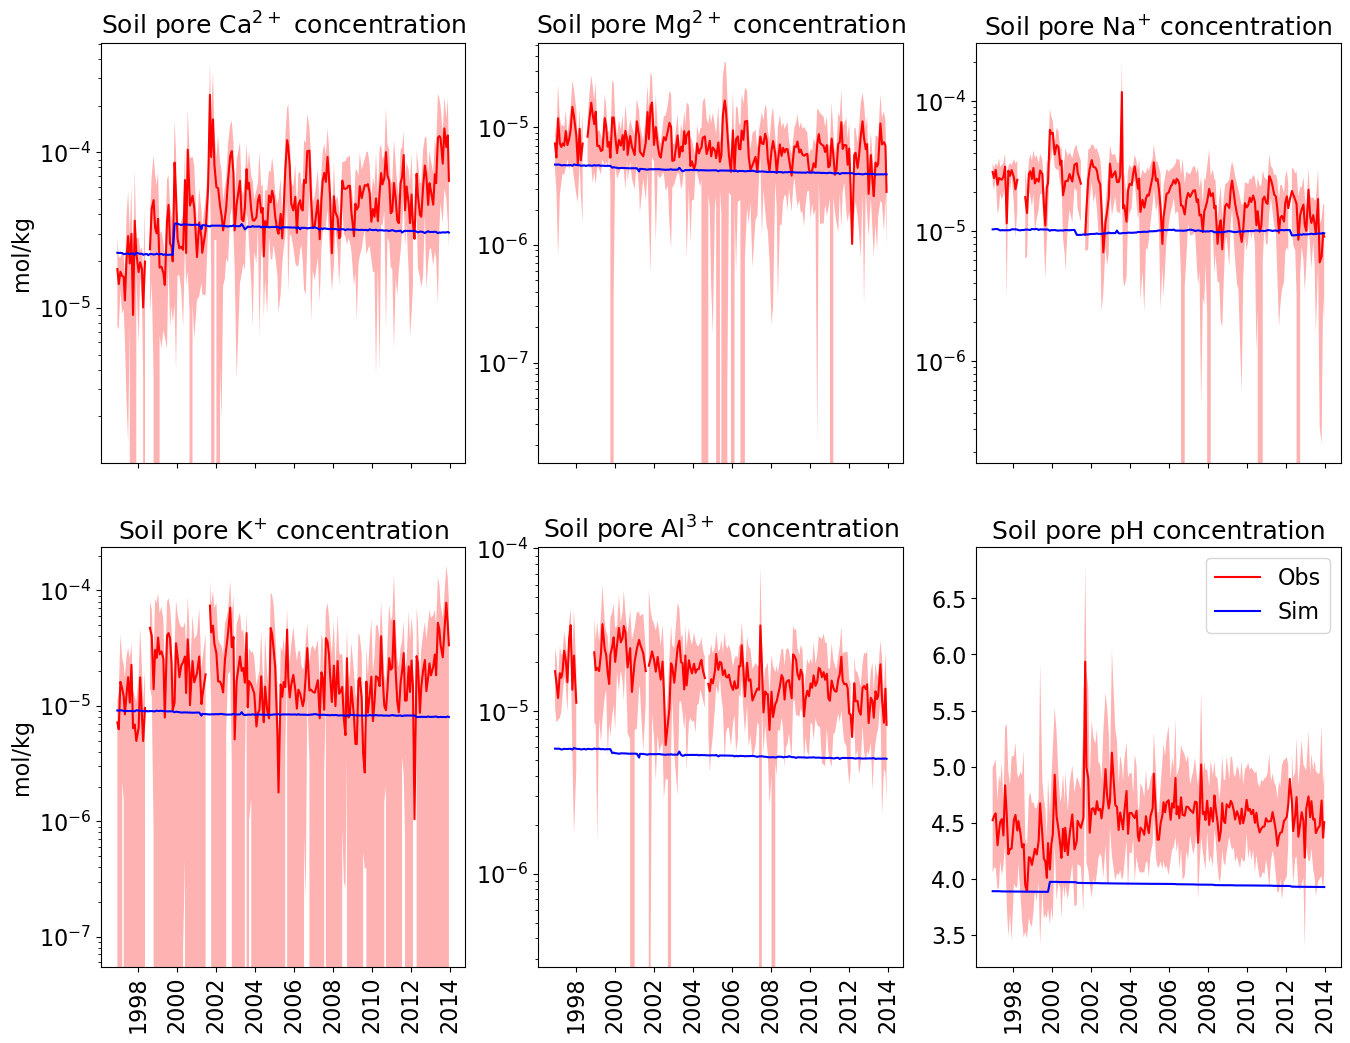

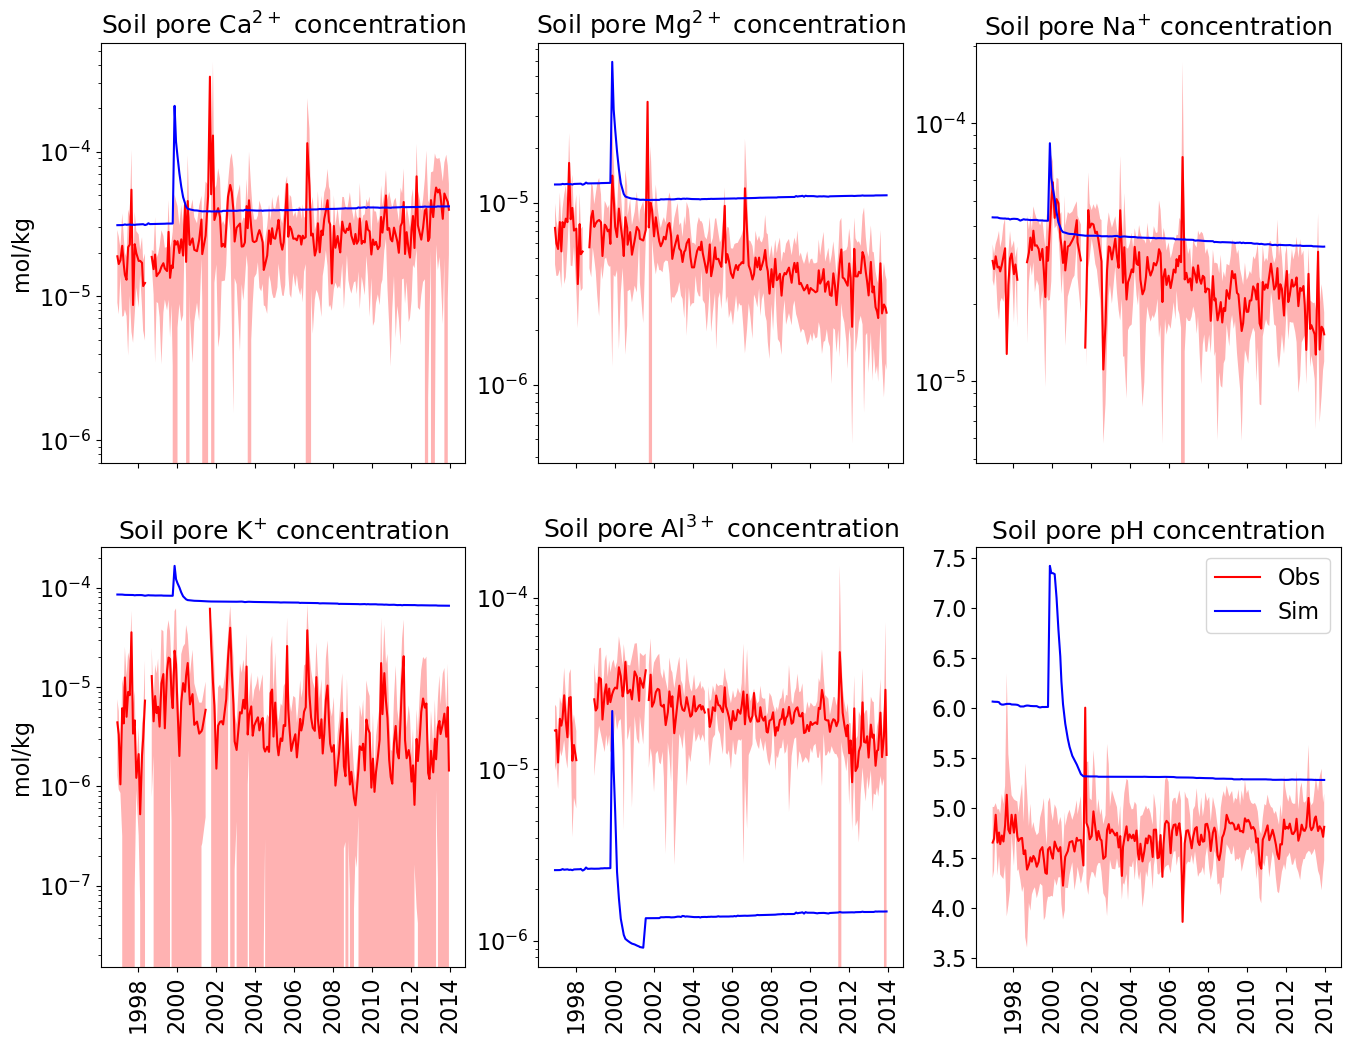

In [36]:
# Layerwise soil pore water cation concentration

soil_pore_obs, soil_pore_obs_std = read_lysimeter()

# Oae - 7cm, the first 3 layers
# Bhs - Bs: the 30cm layer

# convert from g m-3 soil to mol/kg porewater
soil_pore_sim = {}
for i, (cation, mass_ca) in \
    enumerate(zip(['Ca2+','Mg2+','Na+','K+','Al3+'], 
                  [40, 24, 23, 29, 27])):
    soil_pore_sim[(cation, 'Oae')] = pd.Series( 
        ((hr[f'cation_vr_{i+1}'][:,:3,0] / hr['H2OSOI'][:,:3,0] / mass_ca / 1000) *
        hr['levgrnd'].values[:3].reshape(1,-1)).sum(axis = 1) / hr['levgrnd'].values[:3].sum(), 
        index = tvec)
    soil_pore_sim[(cation, 'Bhs')] = pd.Series( 
        hr[f'cation_vr_{i+1}'][:,5,0] / hr['H2OSOI'][:,5,0] / mass_ca / 1000, 
        index = tvec)
soil_pore_sim[('pH', 'Oae')] = pd.Series( 
        (hr[f'soil_pH'][:,:3,0] * hr['levgrnd'].values[:3].reshape(1,-1)).sum(axis = 1) / hr['levgrnd'].values[:3].sum(), 
        index = tvec)
soil_pore_sim[('pH', 'Bhs')] = pd.Series(hr[f'soil_pH'][:,5,0], index = tvec)
soil_pore_sim = pd.DataFrame(soil_pore_sim).stack()
soil_pore_sim.index = soil_pore_sim.index.reorder_levels([1, 0])
soil_pore_sim = soil_pore_sim.sort_index()

for layer in ['Oae', 'Bhs']:
    obs = soil_pore_obs.loc[layer, :]
    obs_std = soil_pore_obs_std.loc[layer, :]
    sim = soil_pore_sim.loc[layer, :]

    index = obs.index.intersection(obs_std.index).intersection(sim.index)
    obs = obs.loc[index, :]
    obs_std = obs_std.loc[index, :]
    sim = sim.loc[index, :]

    fig, axes = plt.subplots(2, 3, figsize = (16, 12), sharex = True)
    for i, (obs_ca, sim_ca, name) in enumerate(
        zip(['Ca2+', 'Mg2+', 'Na+', 'K+', 'Alt', 'pH'],
            ['Ca2+','Mg2+','Na+','K+','Al3+', 'pH'], 
            ['Ca$^{2+}$', 'Mg$^{2+}$', 'Na$^{+}$', 'K$^{+}$', 'Al$^{3+}$', 'pH'])
    ):
        ax = axes.flat[i]
        ax.plot(index, obs[obs_ca], '-r', label = 'Obs')
        ax.fill_between(
            index, obs[obs_ca] - obs_std[obs_ca], obs[obs_ca] + obs_std[obs_ca], 
            fc = 'r', alpha = 0.3
        )
        ax.plot(index, sim[sim_ca], '-b', label = 'Sim')

        ax.set_xlabel('')
        if np.mod(i, 3) == 0:
            ax.set_ylabel('mol/kg')
        if sim_ca != 'pH':
            ax.set_yscale('log')
        ax.set_title(f'Soil pore {name} concentration')
        plt.setp(ax.get_xticklabels(), rotation = 90)
    ax.legend()
    fig.savefig(f'./temp/hbr_soil_pore_water_{layer}.png', dpi = 600., bbox_inches = 'tight')

/autofs/nccsopen-svm1_home/ywo/Git/erw_scripts/shared_read_HBR.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data',
/autofs/nccsopen-svm1_home/ywo/Git/erw_scripts/shared_read_HBR.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data',


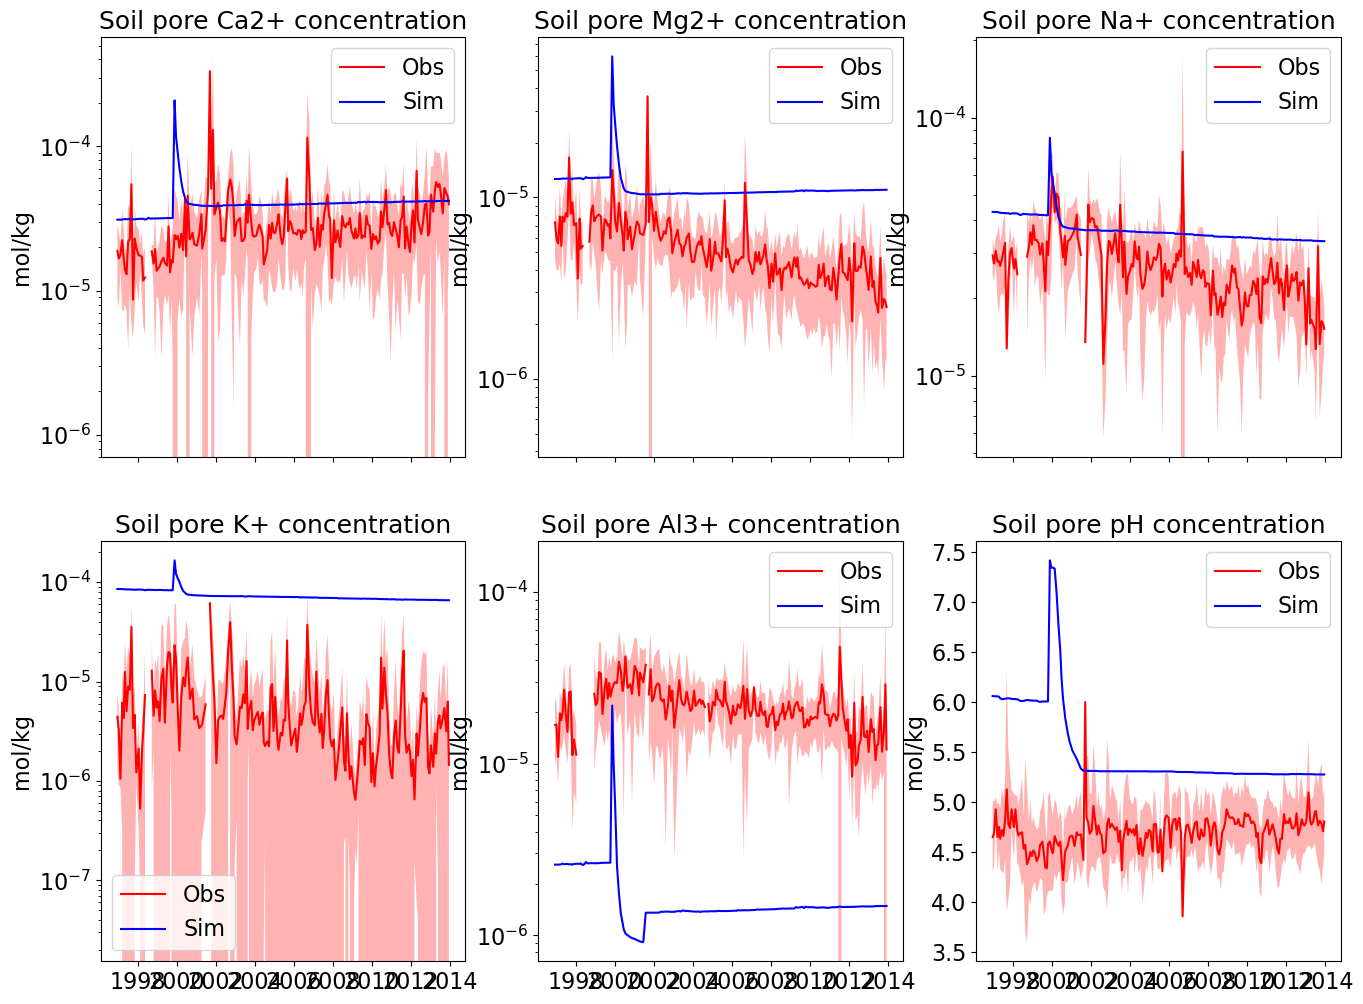

In [23]:
# Integrated soil cation concentration
# Note: the modeled results look very smooth because they are sampled from individual dates

# Oae - 7cm, the first 3 layers
# Bhs - Bs: the 30cm layer
soil_pore_obs, soil_pore_obs_std = read_lysimeter()
soil_pore_obs = (soil_pore_obs.loc['Oae', :] + soil_pore_obs.loc['Bhs', :]) * 0.5
soil_pore_obs_std = ((soil_pore_obs_std.loc['Oae',:]**2 + soil_pore_obs_std.loc['Bhs',:]**2)/2)**0.5

# calcium: convert from g m-3 soil to mol/kg porewater
soil_pore_sim = {}
for i, (cation, mass_ca) in \
    enumerate(zip(['Ca2+','Mg2+','Na+','K+','Al3+'], 
                  [40, 24, 23, 29, 27])):
    soil_pore_sim[cation] = pd.Series( 
        ((hr[f'cation_vr_{i+1}'][:,:6,0] / hr['H2OSOI'][:,:6,0] / mass_ca / 1000) *
          hr['levgrnd'].values[:6].reshape(1,-1)).sum(axis = 1) / hr['levgrnd'].values[:6].sum(),
        index = tvec)
soil_pore_sim['pH'] = pd.Series( 
        (hr[f'soil_pH'][:,:6,0] * hr['levgrnd'].values[:6].reshape(1,-1)).sum(axis = 1) / \
         hr['levgrnd'].values[:6].sum(), index = tvec)
soil_pore_sim = pd.DataFrame(soil_pore_sim)
soil_pore_sim = soil_pore_sim.sort_index()

index = soil_pore_obs.index.intersection(soil_pore_obs_std.index).intersection(soil_pore_sim.index)
obs = obs.loc[index, :]
obs_std = obs_std.loc[index, :]
sim = sim.loc[(sim.index >= index[0]) & (sim.index <= index[-1]), :]

fig, axes = plt.subplots(2, 3, figsize = (16, 12), sharex = True)
for i, (obs_ca, sim_ca) in enumerate(
    zip(['Ca2+', 'Mg2+', 'Na+', 'K+', 'Alt', 'pH'],
        ['Ca2+','Mg2+','Na+','K+','Al3+', 'pH'])
):
    ax = axes.flat[i]
    ax.plot(index, obs[obs_ca], '-r', label = 'Obs')
    ax.fill_between(
        index, obs[obs_ca] - obs_std[obs_ca], obs[obs_ca] + obs_std[obs_ca], 
        fc = 'r', alpha = 0.3
    )
    ax.plot(sim.index, sim[sim_ca], '-b', label = 'Sim')

    ax.set_xlabel('')
    ax.set_ylabel('mol/kg')
    if sim_ca != 'pH':
        ax.set_yscale('log')
    ax.legend()
    ax.set_title(f'Soil pore {sim_ca} concentration')
fig.savefig(f'./temp/hbr_soil_pore_water_average.png', dpi = 600., bbox_inches = 'tight')

In [11]:
hsurf = xr.open_dataset(os.path.join(os.environ['PROJDIR'], 'E3SM', 'inputdata', 'lnd', 
                                     'clm2', 'PTCLM', 'HBR', 'surfdata_erw.nc'))
cec_tot = hsurf['CEC_TOT'][:, 0, 0].values
hsurf.close()

In [12]:
cec_obs_mean, cec_obs_std = read_cec()

# calcium: convert from g m-3 soil to mol/kg porewater
soil_cec_sim = {}
for i, (cation, mass_ca) in \
    enumerate(zip(['Ca2+','Mg2+','Na+','K+','Al3+'], 
                  [40, 24, 23, 29, 27])):
    soil_cec_sim[(cation, 'Oie')] = pd.Series ( \
        (hr[f'cec_cation_vr_{i+1}'][:,:2,0] * hr['levgrnd'].values[:2].reshape(1,-1) \
         ).sum(axis = 1) / hr['levgrnd'].values[:2].sum(),
        index = tvec)
    soil_cec_sim[(cation, 'Oa')] = pd.Series (hr[f'cec_cation_vr_{i+1}'][:,2,0], index = tvec)
    soil_cec_sim[(cation, 'Min')] = pd.Series (hr[f'cec_cation_vr_{i+1}'][:,3,0], index = tvec)
soil_cec_sim[('H+', 'Oie')] = pd.Series ( \
        (hr['cec_proton_vr'][:,:2,0] * hr['levgrnd'].values[:2].reshape(1,-1) \
         ).sum(axis = 1) / hr['levgrnd'].values[:2].sum(),
        index = tvec)
soil_cec_sim[('H+', 'Oa')] = pd.Series (hr['cec_proton_vr'][:,2,0], index = tvec)
soil_cec_sim[('H+', 'Min')] = pd.Series (hr['cec_proton_vr'][:,3,0], index = tvec)

soil_cec_sim = pd.DataFrame(soil_cec_sim).resample('1Y').mean()
soil_cec_sim.index = soil_cec_sim.index.year
soil_cec_sim = soil_cec_sim.stack()
soil_cec_sim.index = soil_cec_sim.index.reorder_levels([1, 0])
soil_cec_sim = soil_cec_sim.sort_index()

# Convert to beta values (fraction)
cec_obs = cec_obs_mean / cec_obs_mean.sum(axis = 1).values.reshape(-1, 1)
cec_sim = soil_cec_sim / soil_cec_sim.sum(axis = 1).values.reshape(-1, 1)

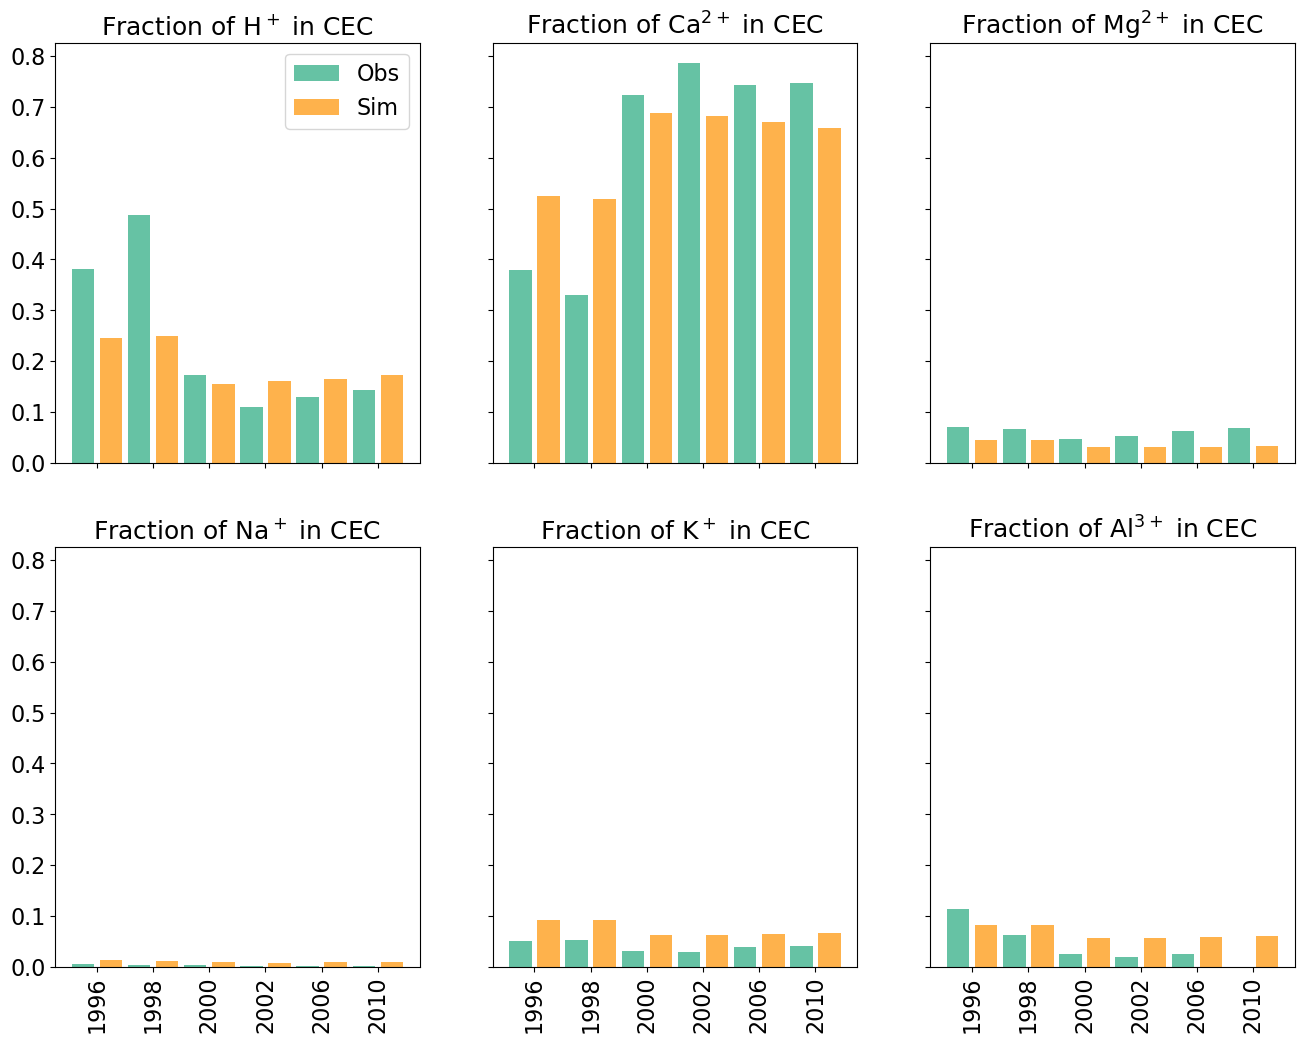

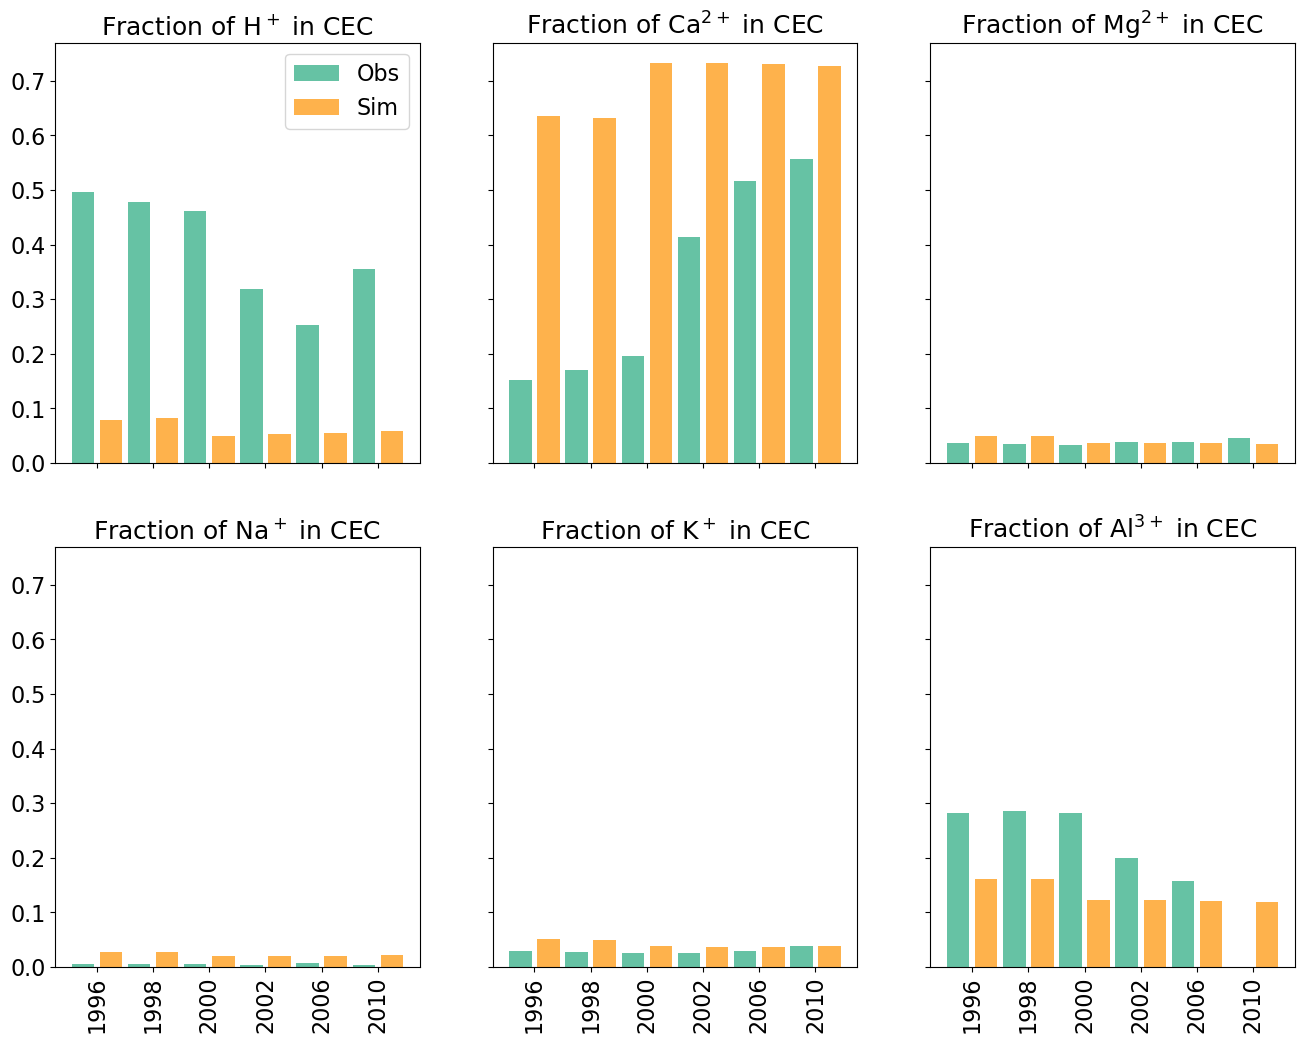

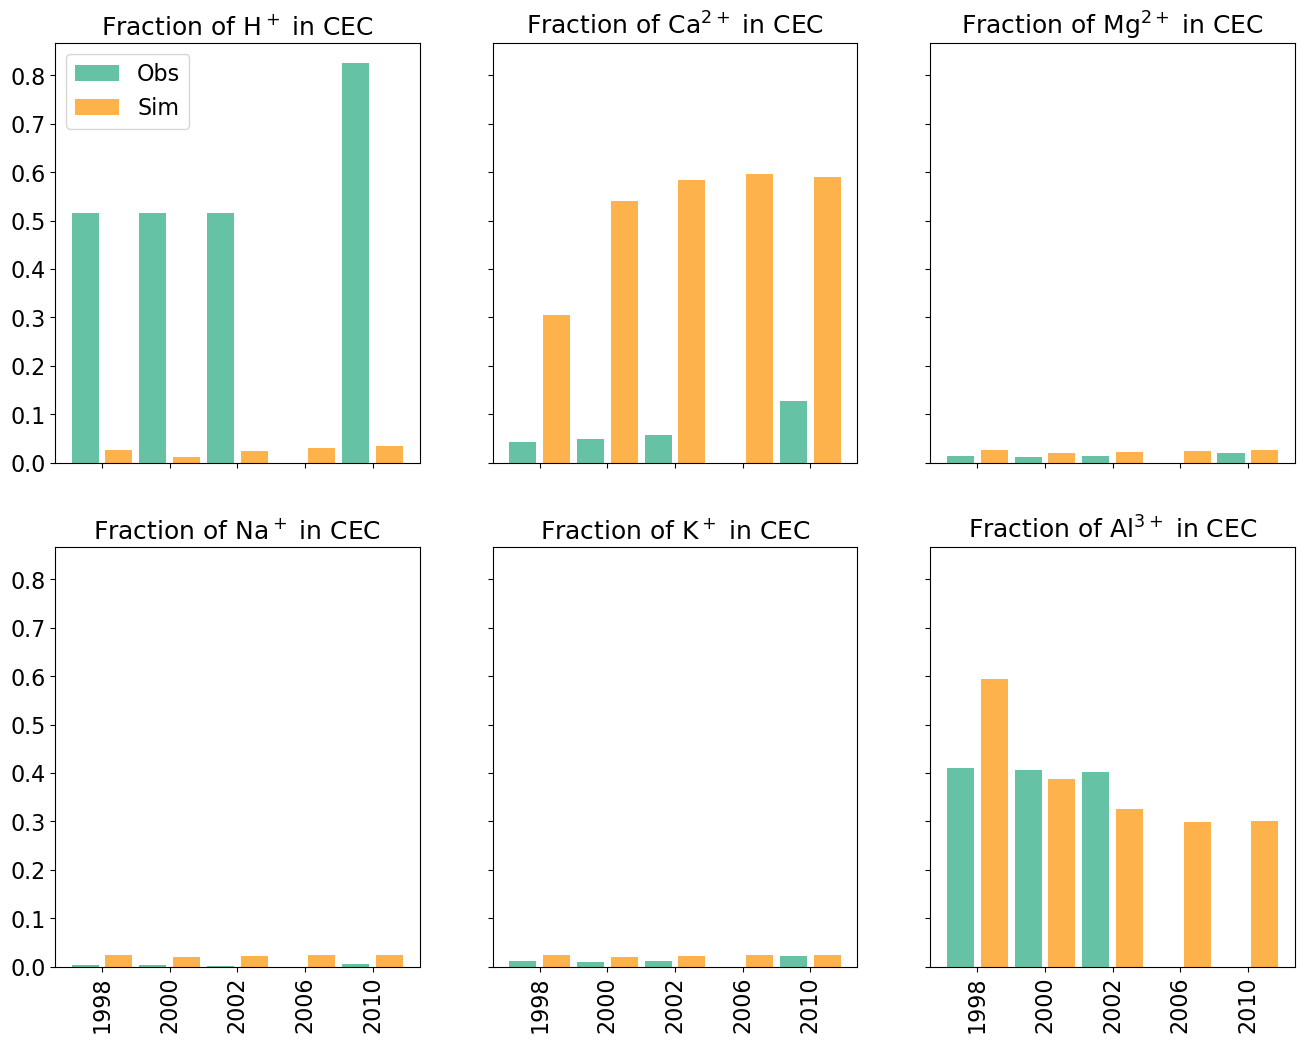

In [38]:
for i, horizon in enumerate(['Oie', 'Oa', 'Min']):
    fig, axes = plt.subplots(2, 3, figsize = (16, 12), sharex = True, sharey = True)
    for j, (col_obs, col_sim, name) in enumerate(zip(
        ['ExAcidcmolc_kg', 'ExCacmolc_kg', 'ExMgcmolc_kg', 'ExNacmolc_kg', 
        'ExKcmolc_kg', 'ExAlcmolc_kg'], 
        ['H+', 'Ca2+', 'Mg2+', 'Na+', 'K+', 'Al3+'],
        ['H$^+$', 'Ca$^{2+}$', 'Mg$^{2+}$', 'Na$^+$', 'K$^+$', 'Al$^{3+}$']
    )):
        ax = axes.flat[j]

        clist = ['#66c2a4','#feb24c']

        obs = cec_obs.loc[horizon, col_obs]
        sim = cec_sim.loc[horizon, col_sim]
        sim = sim.loc[obs.index]

        h1 = ax.bar(np.arange(obs.shape[0]) * 2, obs, facecolor = clist[0])
        h2 = ax.bar(np.arange(sim.shape[0]) * 2 + 1, sim, facecolor = clist[1])

        ax.set_xticks(np.arange(obs.shape[0])*2 + 0.5)
        ax.set_xticklabels(obs.index)
        ax.set_title(f'Fraction of {name} in CEC')

        if j == 0:
            ax.legend([h1, h2], ['Obs', 'Sim'])
        plt.setp(ax.get_xticklabels(), rotation = 90)

    fig.savefig(f'./temp/hbr_soil_pore_water_{horizon}.png', dpi = 600., bbox_inches = 'tight')

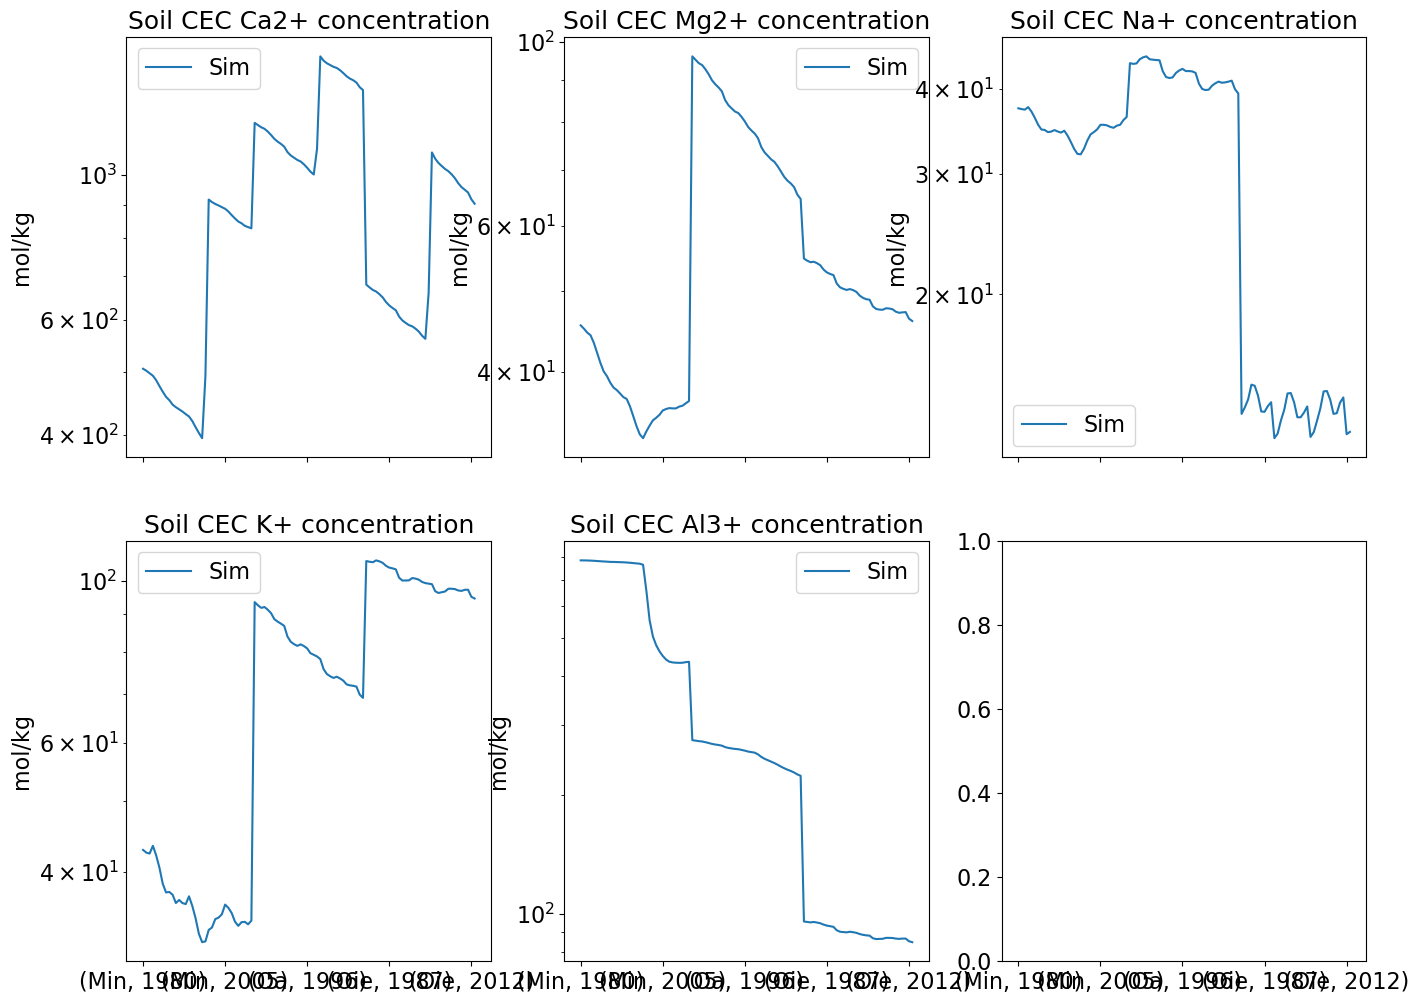

In [15]:
fig, axes = plt.subplots(2, 3, figsize = (16, 12), sharex = True)
for i, (obs_ca, sim_ca) in enumerate(
    zip(['Ca2+', 'Mg2+', 'Na+', 'K+', 'Alt'],
        ['Ca2+','Mg2+','Na+','K+','Al3+'])
):
    ax = axes.flat[i]
    #soil_pore_obs[obs_ca].plot(ax = ax, label = 'Obs')
    soil_cec_sim[sim_ca].plot(ax = ax, label = 'Sim')
    ax.set_xlabel('')
    ax.set_ylabel('mol/kg')
    ax.set_yscale('log')
    ax.legend()
    ax.set_title(f'Soil CEC {sim_ca} concentration')
fig.savefig('./temp/hbr_soil_cec.png', dpi = 600., bbox_inches = 'tight')

In [16]:
hr.close()